# [Neuralink Time Series Forecasting](https://www.tensorflow.org/tutorials/structured_data/time_series)


## Imports


In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from glob import glob
import scipy.io
import IPython

## Configure Tensorflow


In [ ]:
# Identify if the GPU is detected
# tf.config.list_physical_devices()

# Identify if the GPU is being used.
# tf.debugging.set_log_device_placement(False)

## Import Data


In [ ]:
data_dir = "../../data/"
data_file_l = glob(data_dir + "*.wav")
rate, data = scipy.io.wavfile.read(data_file_l[0])
data_df = pd.DataFrame(data, columns=["Amplitude"])
time = np.arange(0, len(data_df) / rate, (1 / rate))
data_df.insert(loc=1, column="Time", value=time, allow_duplicates=True)
data_df.index.name = "Sample Number"
data_df.plot(
    xlabel="Time [s]", x="Time", grid=True, linewidth=0.5, title="Raw Neural Signal"
)

In [ ]:
data_df.__len__()

In [ ]:
df = data_df.drop("Time", axis=1)

## Defining Training, Validation, & Test Sets


In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = df.__len__()

train_df = df[0 : int(n * 0.7)]
val_df = df[int(n * 0.7) : int(n * 0.9)]
test_df = df[int(n * 0.9) :]

num_features = df.shape[1]

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [ ]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name="Column", value_name="Normalized")
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x="Column", y="Normalized", data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [ ]:
class WindowGenerator:
    def __init__(
        self,
        input_width,
        label_width,
        shift,
        train_df=train_df,
        val_df=val_df,
        test_df=test_df,
        label_columns=None,
    ):
        # Store the raw data
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {
                name: i for i, name in enumerate(label_columns)
            }
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return "\n".join(
            [
                f"Total window size: {self.total_window_size}",
                f"Input indices: {self.input_indices}",
                f"Label indices: {self.label_indices}",
                f"Label column name(s): {self.label_columns}",
            ]
        )

In [ ]:
w1 = WindowGenerator(
    input_width=24, label_width=1, shift=24, label_columns=["Amplitude"]
)

In [ ]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1, label_columns=["Amplitude"])

In [ ]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1,
        )

    # Slicing doesn't preserve static shape information, so set the shapes manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels


WindowGenerator.split_window = split_window

In [ ]:
# Stack three slices, the length of the total window.
example_window = tf.stack(
    [
        np.array(train_df[: w2.total_window_size]),
        np.array(train_df[100 : 100 + w2.total_window_size]),
        np.array(train_df[200 : 200 + w2.total_window_size]),
    ]
)

example_inputs, example_labels = w2.split_window(example_window)

print("All shapes are: (batch, time, features)")
print(f"Window shape: {example_window.shape}")
print(f"Inputs shape: {example_inputs.shape}")
print(f"Labels shape: {example_labels.shape}")

In [ ]:
w2.example = example_inputs, example_labels

In [ ]:
def plot(self, model=None, plot_col="Amplitude", max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n + 1)
        plt.ylabel(f"{plot_col} [normed]")
        plt.plot(
            self.input_indices,
            inputs[n, :, plot_col_index],
            label="Inputs",
            marker=".",
            zorder=-10,
        )

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(
            self.label_indices,
            labels[n, :, label_col_index],
            edgecolors="k",
            label="Labels",
            c="#2ca02c",
            s=64,
        )
        if model is not None:
            predictions = model(inputs)
            plt.scatter(
                self.label_indices,
                predictions[n, :, label_col_index],
                marker="X",
                edgecolors="k",
                label="Predictions",
                c="#ff7f0e",
                s=64,
            )

        if n == 0:
            plt.legend()

    plt.xlabel("Time [h]")


WindowGenerator.plot = plot

In [ ]:
w2.label_columns_indices

In [ ]:
w2.plot()

In [ ]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,
    )
    ds = ds.map(self.split_window)

    return ds


WindowGenerator.make_dataset = make_dataset

In [ ]:
@property
def train(self):
    return self.make_dataset(self.train_df)


@property
def val(self):
    return self.make_dataset(self.val_df)


@property
def test(self):
    return self.make_dataset(self.test_df)


@property
def example(self):
    """get and cache an example batch of `inputs, labels` for ploting."""
    result = getattr(self, "_example", None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result


WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

In [ ]:
for example_inputs, example_labels in w2.train.take(1):
    print(f"Inputs shape (batch, time, features): {example_inputs.shape}")
    print(f"Labels shape (batch, time, features): {example_labels.shape}")

## Single Step Model


In [ ]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1, label_columns=["Amplitude"]
)
single_step_window

In [ ]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f"Inputs shape (batch, time, features): {example_inputs.shape}")
    print(f"Labels shape (batch, time, features): {example_labels.shape}")

### Baseline


In [ ]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [ ]:
baseline = Baseline(label_index=column_indices["Amplitude"])

baseline.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()],
)

val_performance = {}
performance = {}
val_performance["Baseline"] = baseline.evaluate(
    single_step_window.val, return_dict=True
)
performance["Baseline"] = baseline.evaluate(
    single_step_window.test, verbose=0, return_dict=True
)

In [ ]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1, label_columns=["Amplitude"]
)
wide_window

In [ ]:
print("Input shape:", wide_window.example[0].shape)
print("Output shape:", baseline(wide_window.example[0]).shape)

In [ ]:
wide_window.plot(baseline)

### Linear Model


In [ ]:
linear = tf.keras.Sequential([tf.keras.layers.Dense(units=1)])

In [ ]:
print("Input shape:", single_step_window.example[0].shape)
print("Output shape:", linear(single_step_window.example[0]).shape)

In [ ]:
MAX_EPOCHS = 20


def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=patience, mode="min"
    )

    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=[tf.keras.metrics.MeanAbsoluteError()],
    )

    history = model.fit(
        window.train,
        epochs=MAX_EPOCHS,
        validation_data=window.val,
        callbacks=[early_stopping],
    )
    return history

In [ ]:
history = compile_and_fit(linear, single_step_window)

val_performance["Linear"] = linear.evaluate(single_step_window.val, return_dict=True)
performance["Linear"] = linear.evaluate(
    single_step_window.test, verbose=0, return_dict=True
)

In [ ]:
print("Input shape:", wide_window.example[0].shape)
print("Output shape:", wide_window.example[0].shape)

In [ ]:
wide_window.plot(linear)

In [ ]:
linear.layers[0].kernel[:, 0].numpy()

In [ ]:
# Visualizing the model's weights assigned to each input

plt.bar(x=range(len(train_df.columns)), height=linear.layers[0].kernel[:, 0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

### Dense


In [ ]:
dense = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(units=64, activation="relu"),
        tf.keras.layers.Dense(units=64, activation="relu"),
        tf.keras.layers.Dense(units=1),
    ]
)

history = compile_and_fit(dense, single_step_window)

val_performance["Dense"] = dense.evaluate(single_step_window.val, return_dict=True)
performance["Dense"] = dense.evaluate(
    single_step_window.test, verbose=0, return_dict=True
)

In [ ]:
wide_window.plot(dense)

In [ ]:
wide_window.plot(linear)

### Multi-step dense


In [ ]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH, label_width=1, shift=1, label_columns=["Amplitude"]
)
conv_window

In [ ]:
conv_window.plot()
plt.suptitle("Given 3 hours of inputs, predict 1 hour into the future.")

In [ ]:
multi_step_dense = tf.keras.Sequential(
    [
        # Shape: (time, features) => (time*features)
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=32, activation="relu"),
        tf.keras.layers.Dense(units=32, activation="relu"),
        tf.keras.layers.Dense(units=1),
        # Add back the time dimension.
        # Shape: (outputs) => (1, outputs)
        tf.keras.layers.Reshape([1, -1]),
    ]
)

In [ ]:
print("Input shape:", conv_window.example[0].shape)
print("Output shape:", multi_step_dense(conv_window.example[0]).shape)

In [134]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance["Multi step dense"] = multi_step_dense.evaluate(
    conv_window.val, return_dict=True
)
performance["Multi step dense"] = multi_step_dense.evaluate(
    conv_window.test, verbose=0, return_dict=True
)

1847/2159 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0854 - mean_absolute_error: 0.2322

In [ ]:
conv_window.plot(multi_step_dense)

In [ ]:
# This method is only compatible with inputs of a specific shape.

print("Input shape:", wide_window.example[0].shape)
try:
    print("Output shape:", multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
    print(f"\n{type(e).__name__}:{e}")

### Convolutional Neural Network


In [ ]:
conv_model = tf.keras.Sequential(
    [
        tf.keras.layers.Conv1D(
            filters=32, kernel_size=(CONV_WIDTH,), activation="relu"
        ),
        tf.keras.layers.Dense(units=32, activation="relu"),
        tf.keras.layers.Dense(units=1),
    ]
)

In [ ]:
print("Conv model on `conv_window`")
print("Input shape:", conv_window.example[0].shape)
print("Output shape:", conv_model(conv_window.example[0]).shape)

In [ ]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance["Conv"] = conv_model.evaluate(conv_window.val, return_dict=True)
performance["Conv"] = conv_model.evaluate(conv_window.test, verbose=0, return_dict=True)

In [ ]:
print("Wide window")
print("Input shape:", wide_window.example[0].shape)
print("Labels shape:", wide_window.example[1].shape)
print("Output shape:", conv_model(wide_window.example[0]).shape)

In [ ]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=["Amplitude"],
)

wide_conv_window

In [ ]:
print("Wide conv window")
print("Input shape:", wide_conv_window.example[0].shape)
print("Labels shape:", wide_conv_window.example[1].shape)
print("Output shape:", conv_model(wide_conv_window.example[0]).shape)

In [ ]:
wide_conv_window.plot(conv_model)

### Recurrent Neural Network


In [ ]:
lstm_model = tf.keras.models.Sequential(
    [
        # Shape [batch, time, features] => [batch, time, lstm_units]
        tf.keras.layers.LSTM(32, return_sequences=True),
        # Shape => [batch, time, features]
        tf.keras.layers.Dense(units=1),
    ]
)

In [ ]:
print("Input shape:", wide_window.example[0].shape)
print("Output shape:", lstm_model(wide_window.example[0]).shape)

In [ ]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance["LSTM"] = lstm_model.evaluate(wide_window.val, return_dict=True)
performance["LSTM"] = lstm_model.evaluate(wide_window.test, verbose=0, return_dict=True)

In [ ]:
wide_window.plot(lstm_model)

### Performance


In [ ]:
cm = lstm_model.metrics[1]
cm.metrics

In [ ]:
val_performance

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_name = "mean_absolute_error"
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]

plt.ylabel("mean_absolute_error [Amplitude, normalized]")
plt.bar(x - 0.17, val_mae, width, label="Validation")
plt.bar(x + 0.17, test_mae, width, label="Test")
plt.xticks(ticks=x, labels=performance.keys(), rotation=45)
_ = plt.legend()

In [ ]:
for name, value in performance.items():
    print(f"{name:12s}: {value[metric_name]:0.4f}")

### Multi-output models


In [ ]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you
    # don't set the `label_columns` argument.
    input_width=1,
    label_width=1,
    shift=1,
)

wide_window = WindowGenerator(input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
    print(f"Inputs shape (batch, time, features): {example_inputs.shape}")
    print(f"Labels shape (batch, time, features): {example_labels.shape}")

#### Baseline


In [ ]:
baseline = Baseline()
baseline.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()],
)

In [ ]:
val_performance = {}
performance = {}
val_performance["Baseline"] = baseline.evaluate(wide_window.val, return_dict=True)
performance["Baseline"] = baseline.evaluate(
    wide_window.test, verbose=0, return_dict=True
)

#### Dense


In [ ]:
dense = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(units=64, activation="relu"),
        tf.keras.layers.Dense(units=64, activation="relu"),
        tf.keras.layers.Dense(units=num_features),
    ]
)

#### RNN


In [ ]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1
)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val, return_dict=True)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0, return_dict=True)

print()

#### Advanced Residual Connections


In [ ]:
class ResidualWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)

        # The prediction for each time step is the input
        # from the previous time step plut the delta
        # calculated by the model.
        return inputs + delta

In [ ]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
        tf.keras.layers.LSTM(32, return_sequences=True),
        tf.keras.layers.Dense(
            num_features, 
            # The predicted deltas should start small.
            # Therefore, initialize the output layer with zeros.
            kernel_initializer=tf.initializers.zeros()
        )
    ]
    )
)

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val, return_dict=True)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0, return_dict=True)
print()

#### Performance


In [ ]:
x = np.arange(len(performance))
width = 0.3

metric_name = "mean_absolute_error"
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label="Validation")
plt.bar(x + 0.17, test_mae, width, label="Test")
plt.xticks(ticks=x, labels=performance.keys(), rotation=45)
plt.ylabel("MAE (average over all outputs)")
_ = plt.legend()

In [ ]:
for name, value in performance.items():
    print(f"{name:15s}: {value[metric_name]:0.4f}")

### Multi-step models


In [ ]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24, label_width=OUT_STEPS, shift=OUT_STEPS)

multi_window.plot()
multi_window

In [ ]:
class MultiStepLastBaseline(tf.keras.Model):
    def call(self, inputs):
        tile = tf.tile(inputs[:, -1, :], [1, OUT_STEPS, 1])
        return tile

In [ ]:
last_baseline = MultiStepLastBaseline()
last_baseline.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()],
)

In [ ]:
multi_val_performance = {}
multi_performance = {}

In [ ]:
multi_window.val

In [ ]:
# multi_val_performance["Last"] = last_baseline.evaluate(
#     multi_window.val, return_dict=True
# )
# multi_performance["Last"] = last_baseline.evaluate(
#     multi_window.test, verbose=0, return_dict=True
# )

### Repeat Baseline


In [ ]:
class RepeatBaseline(tf.keras.Model):
    def call(self, inputs):
        return inputs


repeat_baseline = RepeatBaseline()
repeat_baseline.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()],
)

In [ ]:
multi_val_performance["Repeat"] = repeat_baseline.evaluate(
    multi_window.val, return_dict=True
)
multi_performance["Repeat"] = repeat_baseline.evaluate(
    multi_window.test, verbose=0, return_dict=True
)
multi_window.plot(repeat_baseline)

### Single-shot models


In [ ]:
multi_linear_model = tf.keras.Sequential(
    [
        # Take the last time-step.
        # Shape [batch, time, features] => [batch, 1, features]
        tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
        # Shape => [batch, 1, out_steps*features]
        tf.keras.layers.Dense(
            OUT_STEPS * num_features, kernel_initializer=tf.initializers.zeros()
        ),
        # Shape => [batch, out_steps, features]
        tf.keras.layers.Reshape([OUT_STEPS, num_features]),
    ]
)

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance["Linear"] = multi_linear_model.evaluate(
    multi_window.val, return_dict=True
)
multi_performance["Linear"] = multi_linear_model.evaluate(
    multi_window.test, verbose=0, return_dict=True
)
multi_window.plot(multi_linear_model)

### Dense Multi-Output Model


In [ ]:
multi_dense_model = tf.keras.Sequential(
    [
        # Take the last time step.
        # Shape [batch, time, features] => [batch, 1, features]
        tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
        # Shape => [batch, 1, dense_units]
        tf.keras.layers.Dense(512, activation="relu"),
        # Shape => [batch, out_steps*features]
        tf.keras.layers.Dense(
            OUT_STEPS * num_features, kernel_initializer=tf.initializers.zeros()
        ),
        # Shape => [batch, out_steps, features]
        tf.keras.layers.Reshape([OUT_STEPS, num_features]),
    ]
)

history = compile_and_fit(multi_dense_model, multi_window)

In [ ]:
IPython.display.clear_output()
multi_val_performance["Dense"] = multi_dense_model.evaluate(
    multi_window.val, return_dict=True
)
multi_performance["Dense"] = multi_dense_model.evaluate(
    multi_window.test, verbose=0, return_dict=True
)
multi_window.plot(multi_dense_model)

#### CNN


In [ ]:
import IPython.display


CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential(
    [
        # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
        tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
        # Shape => [batch, 1, conv_units]
        tf.keras.layers.Conv1D(256, activation="relu", kernel_size=(CONV_WIDTH)),
        # Shape => [batch, 1, out_steps*features]
        tf.keras.layers.Dense(
            OUT_STEPS * num_features, kernel_initializer=tf.initializers.zeros()
        ),
        # Shape => [batch, out_steps, features]
        tf.keras.layers.Reshape([OUT_STEPS, num_features]),
    ]
)

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance["Conv"] = multi_conv_model.evaluate(
    multi_window.val, return_dict=True
)
multi_performance["Conv"] = multi_conv_model.evaluate(
    multi_window.test, verbose=0, return_dict=True
)
multi_window.plot(multi_conv_model)

In [ ]:
multi_lstm_model = tf.keras.Sequential(
    [
        # Shape [batch, time, features] => [batch, lstm_units].
        # Adding more`lstm_units` just overfits more quickly.
        tf.keras.layers.LSTM(32, return_sequences=False),
        # Shape => [batch, out_steps*features].
        tf.keras.layers.Dense(
            OUT_STEPS * num_features, kernel_initializer=tf.initializers.zeros()
        ),
        # Shape => [batch, out_steps, features].
        tf.keras.layers.Reshape([OUT_STEPS, num_features]),
    ]
)

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance["LSTM"] = multi_lstm_model.evaluate(
    multi_window.val, return_dict=True
)
multi_performance["LSTM"] = multi_lstm_model.evaluate(
    multi_window.test, verbose=0, return_dict=True
)
multi_window.plot(multi_lstm_model)

### Autoregressive model


#### RNN


In [ ]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in a RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)

In [ ]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [ ]:
def warmup(self, inputs):
    # inputs.shape => (batch, time, features)
    # x.shape => (batch, lstm_units)
    x, *state = self.lstm_rnn(inputs)

    # predictions.shape => (batch, features)
    prediction = self.dense(x)
    return prediction, state


FeedBack.warmup = warmup

In [ ]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

In [ ]:
def call(self, inputs, training=None):
    # Use a TensorArray to capture dynamically unrolled outputs.
    predictions = []
    # Initialize the LSTM state.
    prediction, state = self.warmup(inputs)

    # Insert the first prediction
    predictions.append(prediction)

    # Run the rest of the prediction steps.
    for n in range(1, self.out_steps):
        # Use the last prediction as input.
        x = prediction
        # Execute one lstm step.
        x, state = self.lstm_cell(x, states=state, training=training)
        # Convert the lstm output to a prediction.
        prediction = self.dense(x)
        # add the prediction to the output.
        predictions.append(prediction)

    # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
    # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions


FeedBack.call = call

In [ ]:
print(
    "Output shape (batch, time, features): ",
    feedback_model(multi_window.example[0]).shape,
)

In [ ]:
history = compile_and_fit(feedback_model, multi_window)

In [ ]:
IPython.display.clear_output()

multi_val_performance["AR LSTM"] = feedback_model.evaluate(
    multi_window.val, return_dict=True
)

In [ ]:
multi_performance["AR LSTM"] = feedback_model.evaluate(
    multi_window.test, verbose=0, return_dict=True
)
multi_window.plot(feedback_model)

#### Performance of the AutoRegressive Model


In [ ]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = "mean_absolute_error"
val_mae = [v[metric_name] for v in multi_val_performance.values()]
test_mae = [v[metric_name] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label="Validation")
plt.bar(x + 0.17, test_mae, width, label="Test")
plt.xticks(ticks=x, labels=multi_performance.keys(), rotation=45)
plt.ylabel(f"MAE (average over all times and outputs)")
_ = plt.legend()

In [ ]:
for name, value in multi_performance.items():
    print(f"{name:8s}: {value[metric_name]:0.4f}")

## GRU


### Example GRU


In [2]:
datapath = os.getcwd() + "/data/AMZN_2006-01-01_to_2018-01-01.csv"

In [3]:
datapath

'/Volumes/T7/Github/Neuralink-Compression-Challenge/analysis/tutorials/data/AMZN_2006-01-01_to_2018-01-01.csv'

In [4]:
data = pd.read_csv(datapath)
data = data.sort_values("Date")
data.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN
1,2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN
2,2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN
3,2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN
4,2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN


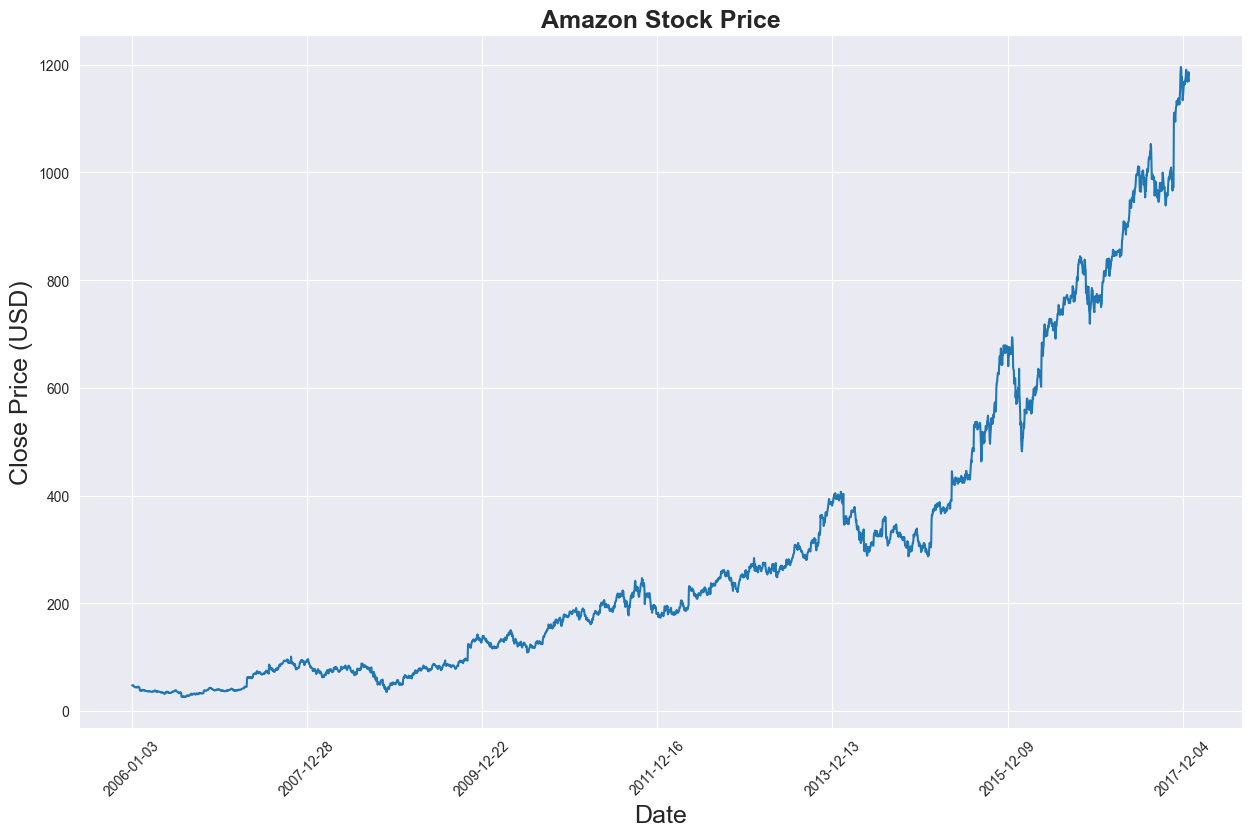

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
plt.figure(figsize=(15, 9))
plt.plot(data[["Close"]])
plt.xticks(range(0, data.shape[0], 500), data["Date"].loc[::500], rotation=45)
plt.title("Amazon Stock Price", fontsize=18, fontweight="bold")
plt.xlabel("Date", fontsize=18)
plt.ylabel("Close Price (USD)", fontsize=18)
plt.show()

##### Normalizing data


In [6]:
price = data[["Close"]]
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   3019 non-null   float64
dtypes: float64(1)
memory usage: 23.7 KB


In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
price["Close"] = scaler.fit_transform(price["Close"].values.reshape(-1, 1))

/var/folders/km/lr9wgyjj0z737tmwxblc5d980000gn/T/ipykernel_17576/2806466906.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price["Close"] = scaler.fit_transform(price["Close"].values.reshape(-1, 1))


In [8]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy()  # convert to numpy array
    data = []

    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index : index + lookback])

    data = np.array(data)
    test_set_size = int(np.round(0.2 * data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)

    x_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, :]

    x_test = data[train_set_size:, :-1]
    y_test = data[train_set_size:, -1, :]

    return [x_train, y_train, x_test, y_test]

In [9]:
import torch
import torch.nn as nn

In [10]:
lookback = 20  # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)
print("x_train.shape = ", x_train.shape)
print("y_train.shape = ", y_train.shape)
print("x_test.shape = ", x_test.shape)
print("y_test.shape = ", y_test.shape)

x_train.shape =  (2399, 19, 1)
y_train.shape =  (2399, 1)
x_test.shape =  (600, 19, 1)
y_test.shape =  (600, 1)


In [11]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [12]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [13]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [14]:
model = GRU(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    num_layers=num_layers,
)
criterion = torch.nn.MSELoss(reduction="mean")
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [15]:
hist = np.zeros(num_epochs)
start_time = time.time()
gru = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time() - start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.46257340908050537
Epoch  1 MSE:  0.20881696045398712
Epoch  2 MSE:  0.053116194903850555
Epoch  3 MSE:  0.06718796491622925
Epoch  4 MSE:  0.08377677202224731
Epoch  5 MSE:  0.037137508392333984
Epoch  6 MSE:  0.028668424114584923
Epoch  7 MSE:  0.04510870203375816
Epoch  8 MSE:  0.05186653137207031
Epoch  9 MSE:  0.0429358072578907
Epoch  10 MSE:  0.02840258926153183
Epoch  11 MSE:  0.020355870947241783
Epoch  12 MSE:  0.024295322597026825
Epoch  13 MSE:  0.031371865421533585
Epoch  14 MSE:  0.02863270975649357
Epoch  15 MSE:  0.019134288653731346
Epoch  16 MSE:  0.013471508398652077
Epoch  17 MSE:  0.014810237102210522
Epoch  18 MSE:  0.018160324543714523
Epoch  19 MSE:  0.01743272878229618
Epoch  20 MSE:  0.011615414172410965
Epoch  21 MSE:  0.005649135913699865
Epoch  22 MSE:  0.005355258472263813
Epoch  23 MSE:  0.008573736995458603
Epoch  24 MSE:  0.006498205941170454
Epoch  25 MSE:  0.0009462835150770843
Epoch  26 MSE:  0.0019019230967387557
Epoch  27 MSE:  0.00

In [16]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train.detach().numpy()))

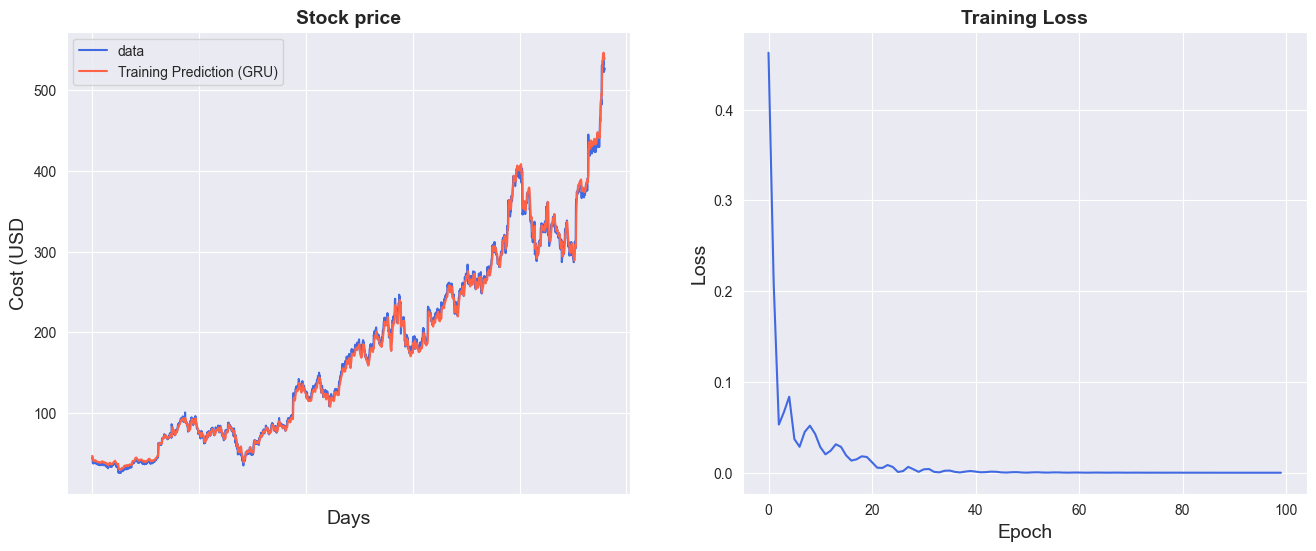

In [17]:
import seaborn as sns

sns.set_style("darkgrid")

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x=original.index, y=original[0], label="data", color="royalblue")
ax = sns.lineplot(
    x=predict.index, y=predict[0], label="Training Prediction (GRU)", color="tomato"
)
ax.set_title("Stock price", size=14, fontweight="bold")
ax.set_xlabel("Days", size=14)
ax.set_ylabel("Cost (USD", size=14)
ax.set_xticklabels("", size=10)

plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color="royalblue")
ax.set_xlabel("Epoch", size=14)
ax.set_ylabel("Loss", size=14)
ax.set_title("Training Loss", size=14, fontweight="bold")
fig.set_figheight(6)
fig.set_figwidth(16)

In [18]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:, 0], y_train_pred[:, 0]))
print("Train Score: %.2f RMSE" % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:, 0], y_test_pred[:, 0]))
print("Test Score: %.2f RMSE" % (testScore))
gru.append(trainScore)
gru.append(testScore)
gru.append(training_time)

Train Score: 5.78 RMSE
Test Score: 40.58 RMSE


In [29]:
price

,Close
0,-0.963223
1,-0.963787
2,-0.963104
3,-0.962727
4,-0.964078
...,...
3014,0.953033
3015,0.967395
3016,0.976799
3017,0.983364


In [19]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback : len(y_train_pred) + lookback, :] = y_train_pred

# shift test prediction for plotting
testPredictPlot = np.empty_like(price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred) + lookback - 1 : len(price) - 1, :] = y_test_pred

original = scaler.inverse_transform(price["Close"].values.reshape(-1, 1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

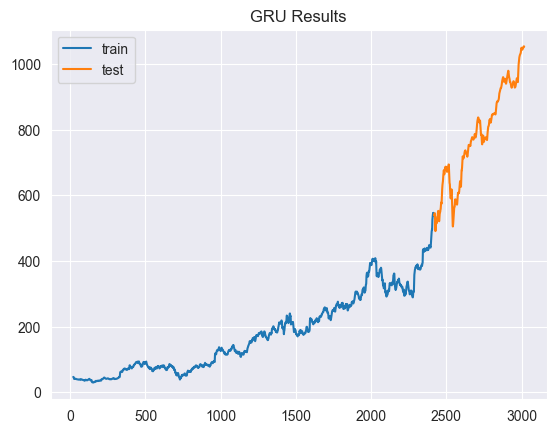

In [30]:
plt.title("GRU Results")
plt.plot(result.index, result[0], label="train")
plt.plot(result.index, result[1], label="test")
# plt.plot(result.index, result[2], label="original", linewidth=0.5)
plt.legend()
plt.show()

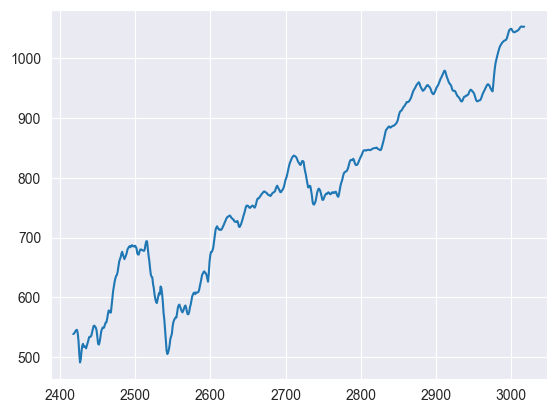

In [21]:
plt.plot(result[1])

In [22]:
sub_original_values = result[2][result[1] > 0]

In [23]:
sub_original_values["Test"] = result[1]

In [24]:
sub_test_values = result[1][result[1] > 0]

In [25]:
sub_original_value

NameError: name 'sub_original_value' is not defined

In [ ]:
sub_test_values

In [ ]:
sub_df = pd.concat([sub_original_values, sub_test_values], axis=1)
sub_df.columns = ["Original", "Test"]

In [ ]:
sub_df["Residuals"] = sub_df["Original"] - sub_df["Test"]

In [ ]:
sub_df.loc[(sub_df["Residuals"] < 1) & (sub_df["Residuals"] > -1)]

In [ ]:
plt.title("Test Values Vs. Original Values")
plt.plot(
    result[2][result[1] > 0].index, result[2][result[1] > 0], label="Original values"
)
plt.plot(result[1], label="Test Values")
plt.plot(sub_df["Residuals"], label="Residuals")
plt.axhline(y=0)
plt.legend()
plt.show()